In [1]:
import os
import warnings
import argparse

import numpy as np
import pandas as pd
import scanpy as sc
import torch

import Riff
os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")

# 1. Set parameters

In [2]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=42)
parser.add_argument("--device", type=int, default=3)
parser.add_argument("--encoder", type=str, default="gin")
parser.add_argument("--decoder", type=str, default="gin")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--alpha_l", type=float, default=4, help="`pow`inddex for `sce` loss")
parser.add_argument("--beta_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.8)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.5)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm") 

# explain model parameters
parser.add_argument("--sample_num", type=int, default=1, help="number of nodes for explaination")
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--mask_act", type=str, default="sigmoid")
parser.add_argument("--mask_bias", action="store_true", default=True)
parser.add_argument("--scheduler", action="store_true", default=True)
parser.add_argument("--max_epoch", type=int, default=10000, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate for explaination")
parser.add_argument("--weight_decay", type=float, default=1e-4, help="weight decay for evaluation")

# RIF parameter
parser.add_argument("--adj_max_num", type=int, default=3)
parser.add_argument("--feat_max_num", type=int, default=-1)
parser.add_argument("--feat_min_num", type=int, default=10)
parser.add_argument("--feat_threshold", type=float, default=2.3)
parser.add_argument("--num_neighbors", type=int, default=7)
parser.add_argument("--num_features", type=int, default=3000) 
parser.add_argument("--sample_name", type=str, default="V1_Breast_Cancer_Block_A_Section_1")
parser.add_argument("--seq_tech", type=str, default="Visium")
parser.add_argument("--cluster_label", type=str, default="fine_annot_type")
parser.add_argument("--data_folder", type=str, default="/home/wcy/code/datasets/10X/")
parser.add_argument("--num_classes", type=int, default=7, help="The number of clusters")
parser.add_argument("--output_folder", type=str, default="/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output/")

args = parser.parse_args(args=['--sample_name', 'V1_Breast_Cancer_Block_A_Section_1']) 
args

Namespace(activation='elu', adj_max_num=3, alpha_l=4, attn_drop=0.1, beta_l=2, cluster_label='fine_annot_type', data_folder='/home/wcy/code/datasets/10X/', decoder='gin', device=3, drop_edge_rate=0.0, encoder='gin', feat_max_num=-1, feat_min_num=10, feat_threshold=2.3, in_drop=0.2, loss_fn='weighted_mse', lr=0.001, mask_act='sigmoid', mask_bias=True, mask_gene_rate=0.8, max_epoch=10000, negative_slope=0.2, norm='batchnorm', num_classes=7, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=7, num_out_heads=1, optimizer='adam', output_folder='/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output/', remask_rate=0.5, replace_rate=0.05, residual=False, sample_name='V1_Breast_Cancer_Block_A_Section_1', sample_num=1, scheduler=True, seeds=42, seq_tech='Visium', warm_up=50, weight_decay=0.0001)

# 2. Preprocessing

In [3]:
Riff.set_random_seed(args.seeds)
data_path = args.data_folder + args.sample_name
adata = Riff.read_10X_Visium_with_label(data_path)

if(args.cluster_label == ""):
    num_classes = args.num_classes
else:
    num_classes = adata.obs[args.cluster_label].nunique()
adata, graph = Riff.build_graph(args, adata, need_preclust=False)

adata_path = os.path.join(args.output_folder, "adata/"+args.sample_name+".h5ad")
adata_imputed = sc.read_h5ad(adata_path)

=============== Contructing graph =================


# 3. SVG detection

In [4]:
selected_feats = set()
for i in range(num_classes):
    torch.cuda.empty_cache()
    print("Domain:" + str(i))
    selected_feat = Riff.find_influential_component(args, adata_imputed, graph, i)
    selected_feats = selected_feats.union(set(selected_feat))

selected_feats = list(selected_feats)
print(str(len(selected_feats)) + "SVG finded!")
svg_path = args.output_folder + "/SVG/" + str(args.sample_name) + ".txt"
f = open(svg_path, 'w')
for line in selected_feats:
    f.write(line+"\n")
f.close()

Domain:0


# Epoch 404: loss: 1.94, p_feat: 0.36:   4%|██████▉                                                                                                                                                                     | 405/10000 [00:54<21:26,  7.46it/s]


Domain:1


# Epoch 178: loss: 2.00, p_feat: 0.15:   2%|███                                                                                                                                                                         | 179/10000 [00:23<21:22,  7.66it/s]


Domain:2


# Epoch 782: loss: 1.89, p_feat: 0.66:   8%|█████████████▍                                                                                                                                                              | 783/10000 [01:40<19:39,  7.81it/s]


Domain:3


# Epoch 793: loss: 2.06, p_feat: 0.57:   8%|█████████████▋                                                                                                                                                              | 794/10000 [01:50<21:22,  7.18it/s]


Domain:4


# Epoch 10: loss: 1.90, p_feat: 0.08:   0%|▏                                                                                                                                                                             | 11/10000 [00:01<21:55,  7.59it/s]


Domain:5


# Epoch 10: loss: 1.96, p_feat: 0.10:   0%|▏                                                                                                                                                                             | 11/10000 [00:02<32:16,  5.16it/s]


Domain:6


# Epoch 10: loss: 1.93, p_feat: 0.06:   0%|▏                                                                                                                                                                             | 11/10000 [00:01<27:52,  5.97it/s]


Domain:7


# Epoch 97: loss: 1.79, p_feat: 0.18:   1%|█▋                                                                                                                                                                            | 98/10000 [00:12<21:17,  7.75it/s]


Domain:8


# Epoch 748: loss: 2.08, p_feat: 0.53:   7%|████████████▉                                                                                                                                                               | 749/10000 [01:40<20:36,  7.48it/s]


Domain:9


# Epoch 396: loss: 2.00, p_feat: 0.28:   4%|██████▊                                                                                                                                                                     | 397/10000 [00:46<18:39,  8.58it/s]


Domain:10


# Epoch 205: loss: 1.93, p_feat: 0.24:   2%|███▌                                                                                                                                                                        | 206/10000 [00:21<17:21,  9.40it/s]


Domain:11


# Epoch 46: loss: 1.89, p_feat: 0.12:   0%|▊                                                                                                                                                                             | 47/10000 [00:05<19:17,  8.60it/s]


Domain:12


# Epoch 389: loss: 2.02, p_feat: 0.31:   4%|██████▋                                                                                                                                                                     | 390/10000 [00:45<18:38,  8.59it/s]


Domain:13


# Epoch 558: loss: 1.95, p_feat: 0.45:   6%|█████████▌                                                                                                                                                                  | 559/10000 [01:02<17:38,  8.92it/s]


Domain:14


# Epoch 597: loss: 2.01, p_feat: 0.43:   6%|██████████▎                                                                                                                                                                 | 598/10000 [01:09<18:10,  8.62it/s]


Domain:15


# Epoch 315: loss: 2.03, p_feat: 0.26:   3%|█████▍                                                                                                                                                                      | 316/10000 [00:35<18:01,  8.96it/s]


Domain:16


# Epoch 138: loss: 1.97, p_feat: 0.14:   1%|██▍                                                                                                                                                                         | 139/10000 [00:16<19:27,  8.44it/s]


Domain:17


# Epoch 459: loss: 2.08, p_feat: 0.33:   5%|███████▉                                                                                                                                                                    | 460/10000 [00:53<18:23,  8.65it/s]


Domain:18


# Epoch 150: loss: 2.07, p_feat: 0.16:   2%|██▌                                                                                                                                                                         | 151/10000 [00:17<19:19,  8.50it/s]


Domain:19


# Epoch 34: loss: 1.96, p_feat: 0.09:   0%|▌                                                                                                                                                                             | 35/10000 [00:04<21:18,  7.80it/s]

938SVG finded!


In [5]:
MoransI = Riff.compute_Moran_mean(adata, graph, svg_path)
print("Morans index: " + str(MoransI.round(4)))

Morans index: 0.6361


# 4. SVG visualization

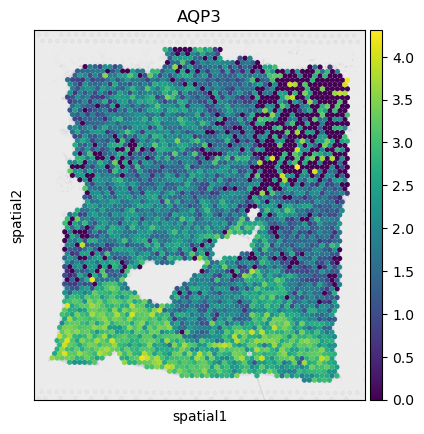

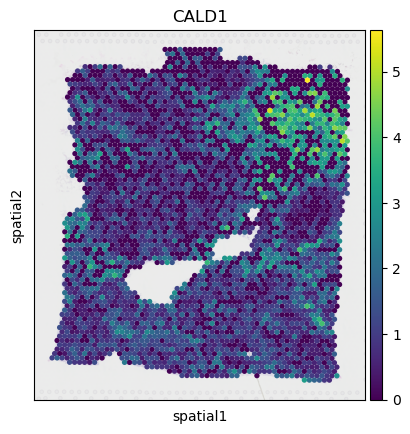

In [9]:
test_gene_list = ['AQP3', 'CALD1']
for gene in test_gene_list:
    if gene in selected_feats:
        sc.pl.spatial(adata, color=gene, s=12, alpha_img=0.3)